Основано на:

- [Inversion over mean](https://gitlab.com/qworld/bronze-qiskit/-/blob/master/quantum-with-qiskit/Q84_Inversion_About_the_Mean.ipynb) QBronze.
- [Grover search](https://gitlab.com/qworld/bronze-qiskit/-/blob/master/quantum-with-qiskit/Q92_Grovers_Search_Implementation.ipynb) QBronze.
- [Wiki](https://en.wikipedia.org/wiki/Grover%27s_algorithm)
- [Qiskit tutorial](https://qiskit.org/textbook/ch-algorithms/grover.html)

# Диффузор Гровера

У этого метода есть несколько названий. Он известен как "итерация Гровера" (Grover iteration), "диффузор Гровера" (Grover diffusor), "усиление комплексной амплитуды" (Amplitude Amplification, AA) или **"обращение относительно среднего"** (inversion/reflection over/about mean). Именно последнее название выражает математическую суть метода поиска помеченных объектов в неупорядоченном массиве. Его мы и разберём.

Этот метод базируется на следующих идеях:
1. Что произойдёт со средним значением массива чисел, если мы отразим относительно него все элементы массива?
2. Насколько изменятся значения элементов массива, если среди них все, кроме одного, одинаковые? $[1, 1, 1, 1, 1, 1, 1, 1, 1, -1] \rightarrow ?$ Насколько сильно изменится отличающееся значение?
3. Как будет меняться ответ на второй вопрос, если отличающихся элементов будет становиться больше?
4. Что будет, если мы сможем поменять знак у отличающихся элементов на противоположный? Сможем ли мы получить существенное отличие в модуле числа?

Попробуйте на бумаге выполнить следующие действия со массивом `[1, 1, 1, 1, 1]`.
1. Обратите все значение относительно среднего.
2. Измените знак 4-го элемента.
3. Обратите все значение относительно среднего.

## Демонстрация
Давайте рассмотрим демонстрацию этих идей. Для этого:

1. Реализуйте недостающие методы.
2. Поменяйте $N$ чтобы понять, как оно влияет на результат.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# 20 элементов в массиве, 100 итераций
W, T = 50, 100

# тут мы будем накапливать результат изменений. 
# i-й cтолбец нашего "холста" будет отражать состояние 
# массива чисел после i-го применения нашего метода.
# на нулевой итерации там просто одинаковые значения
canvas = np.ones((W, T)) / (W ** .5)

# тут будет храниться информация о помеченных элементах
# 0 будет стоять там, где элемент ничем не примечательный
# а 1 -- там где он "интересный" и мы хотим его найти
markers = np.zeros((W,))

# число помеченных элементов
N = 1

# cгенерируем N случайным образом помеченных чисел
for i in range(N):
    markers[random.randrange(canvas.shape[0])] = 1
    
print("Массив markers:", markers)

Массив markers: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [2]:
def invert(markers, vec):
    res = vec.copy()

    # напишите функцию, которая меняет в массиве res
    # знак элемента на противоположный
    # если в массиве markers на этом месте стоит 1.
    
    for i in range(len(markers)):
        if markers[i] != 0:
            res[i] = -res[i]
    
    return res


def reflect_over_mean(vec):
    res = vec.copy()

    # отразите все элементы массива res
    # относительно среднего значения в массиве
    
    s = vec.sum() / len(vec)
    for i in range(len(vec)):
        d = s - vec[i]
        res[i] = (s + d)
    
    return res

Проведём 100 итерация и заполним наш "холст" состояниями массива после этих итераций.

In [3]:
for i in range(1, T):
    inv = invert(markers, canvas[:, i-1])
    ref = reflect_over_mean(inv)
    canvas[:, i] = ref

А теперь нарисуем картинку.

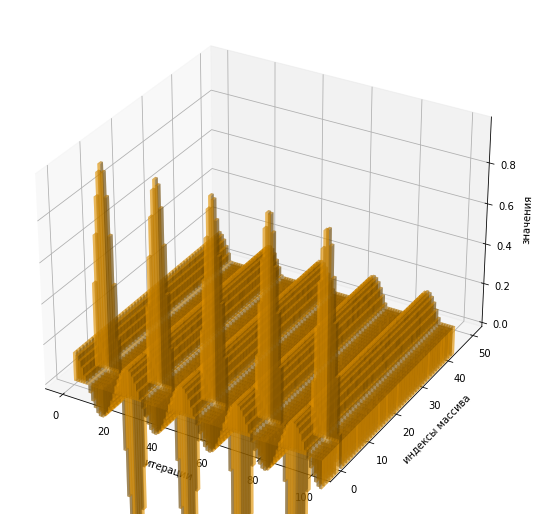

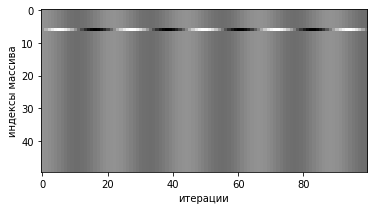

In [12]:
# зададим координатную сетку для 3D-графика
_xx, _yy = np.meshgrid(np.arange(canvas.shape[1]), np.arange(canvas.shape[0]))

# разделим её на x-ы и y-ки в отдельные массивы
x, y = _xx.ravel(), _yy.ravel()

# нарисуем в 3D
heights = [canvas[j, i] for i, j in zip(x, y)]
bottom = np.zeros_like(heights)
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_xlabel("итерации")
ax1.set_ylabel("индексы массива")
ax1.set_zlabel("значения")
ax1.bar3d(x, y, 0, 1, 1, heights, shade=True, alpha=.4, color='orange')
plt.show() 

# и в 2D
plt.figure(figsize=(15, 3))
plt.imshow(canvas, cmap='gray')
plt.xlabel("итерации")
plt.ylabel("индексы массива")
plt.show()

## Матричная форма операции обращения относительно среднего

Итак, мы рассмотрели две важных функции, из которых, по сути, и состоит алгоритм Гровера. Нам осталось только найти их реализацию на квантовом копьютере. Здесь мы остановимся именно на отражении относительно среднего:

Давайте выведем, как можно записать это отражение в виде умножения вектора (массива) на матрицу.

Когда вы реализовывали функции, вы должны были заметить, что новое значение $i$-го элемента массива равно:

$v'_i = 2\bar{v} - v_i = 2\bar{v} - 1*v_i$.

Для всего массива (вектора) $v$ целиком мы можем записать это как:

$v' = 2\bar{v}\mathbb{1} - v = 2*\mathbb{1}\bar{v} - Iv$.

Кстати, что это за матрицы $\mathbb{1}, I$?

Давайте раскроем среднее значение и тоже запишем его в виде матричного произведения:

$\bar{v} = \frac{1}{N}\sum_i{v_i} = \sum_i\frac{1}{N}{v_i}= \frac{1}{N}\mathbb{1}^Tv$

А теперь подставим это в формулу выше:

$v' = 2\frac{1}{N}\mathbb{1}(\mathbb{1}^Tv) - Iv = $

$ = 2\frac{1}{N}(\mathbb{1}\mathbb{1}^T)v - Iv = $

$ = (2\frac{1}{N}\mathbb{E} - I)v$

Итак, мы получили матрицу $(2\frac{1}{N}\mathbb{E} - I)$, не зависящую от значений переменных, на которую можно умножить любой вектор и получить тот же результат, что и в функции `reflect_over_mean(vec)`.
 
## Как нам собрать такую матрицу из квантовых вентилей?

In [ ]:
# матрица, которую мы хотим получить
M = 2 * (1 / 4) * np.ones((4, 4)) - np.eye(4)

# некоторые известные нам квантовые операторы
# вентиль Адамара
H = np.array([[1, 1], [1, -1]]) * (.5 ** .5)
# отрицание
X = np.array([[0, 1], [1, 0]])
# контролируемое изменение фазы
CZ = np.eye((4))
CZ[-1, -1] = -1

print("[H⊗H][X⊗X](CZ)[X⊗X][H⊗H]")
U = np.kron(H, H) @ np.kron(X, X) @ CZ @ np.kron(X, X) @ np.kron(H, H)
print(U)
U = -U
print("-[H⊗H][X⊗X](CZ)[X⊗X][H⊗H]")
print(U)

assert np.allclose(M, U)

Повторим это в виде контура, и проверим, что матрицы совпадают.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

qc = QuantumCircuit(2)

##################################################
# Ваш код здесь. Не обращайте внимание на минус :)
##################################################

qc.h([0, 1])
qc.x([0, 1])
qc.cz(0, 1)
qc.x([0, 1])
qc.h([0, 1])

job = execute(qc, Aer.get_backend('unitary_simulator'))
MX = job.result().get_unitary().real

assert np.allclose(-MX, M)